# Author: Nabil Ibtehaz (https://github.com/nibtehaz)


## Download

In [2]:
!wget https://physionet.org/static/published-projects/ecgiddb/ecg-id-database-1.0.0.zip -P /data/nabil

--2023-08-02 12:07:14--  https://physionet.org/static/published-projects/ecgiddb/ecg-id-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13251711 (13M) [application/zip]
Saving to: ‘/data/nabil/ecg-id-database-1.0.0.zip’

ecg-id-database-1.0 100%[===================>]  12.64M   986KB/s    in 13s     

2023-08-02 12:07:27 (1.01 MB/s) - ‘/data/nabil/ecg-id-database-1.0.0.zip’ saved [13251711/13251711]



In [4]:
!unzip -d /data/nabil/ /data/nabil/ecg-id-database-1.0.0.zip


Archive:  /data/nabil/ecg-id-database-1.0.0.zip
 extracting: /data/nabil/ecg-id-database-1.0.0/SHA256SUMS.txt  
 extracting: /data/nabil/ecg-id-database-1.0.0/RECORDS  
 extracting: /data/nabil/ecg-id-database-1.0.0/biometric.shtml  
 extracting: /data/nabil/ecg-id-database-1.0.0/ANNOTATORS  
 extracting: /data/nabil/ecg-id-database-1.0.0/README  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_3.hea  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_3.atr  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_2.dat  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_4.dat  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_2.hea  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_1.atr  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_4.atr  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_4.hea  
 extracting: /data/nabil/ecg-id-database-1.0.0/Person_42/rec_2.atr  
 extracting: /data/nabil/ecg-

In [24]:
!ls /data/nabil/ecg-id-database-1.0.0/Person_05

rec_1.atr  rec_1.dat  rec_1.hea  rec_2.atr  rec_2.dat  rec_2.hea


## Observe Data

In [1]:
import wfdb

In [2]:
signl, flds = wfdb.rdsamp('/data/nabil/ecg-id-database-1.0.0/Person_15/rec_1')

In [22]:
signl.shape

(10000, 2)

In [3]:
flds

{'fs': 500,
 'sig_len': 10000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['ECG I', 'ECG I filtered'],
 'comments': ['Age: 21', 'Sex: female', 'ECG date: 26.04.2005']}

## Load MAEBank

In [1]:
from MAE1DCorrelated import MaskedAutoencoderViT1DCorrelated
from MAEBank import MAEBank
import torch

/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
mdl_bnk = MAEBank(['cpu'])
mdl_pth = 'experiments/expb3/'
for i in range(12):
    print(f'MAE {i+1} loaded')
    mdl_bnk.maes[i].load_state_dict(
        torch.load(
        f"{mdl_pth}saved_models/mae_channel_{i+1}_best.pth",
        map_location="cpu",
    )
)

Model config
MaskedAutoencoderViT1D(sig_len=2500, window_len=100, in_chans=1,embed_dim=768, depth=12, num_heads=8,decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=512,mlp_ratio=4.0, norm_layer=<class 'torch.nn.modules.normalization.LayerNorm'>, norm_pix_loss=True)
Initializing MAE 1
Initializing MAE 2
Initializing MAE 3
Initializing MAE 4
Initializing MAE 5
Initializing MAE 6
Initializing MAE 7
Initializing MAE 8
Initializing MAE 9
Initializing MAE 10
Initializing MAE 11
Initializing MAE 12
MAE 1 loaded
MAE 2 loaded
MAE 3 loaded
MAE 4 loaded
MAE 5 loaded
MAE 6 loaded
MAE 7 loaded
MAE 8 loaded
MAE 9 loaded
MAE 10 loaded
MAE 11 loaded
MAE 12 loaded


## Generate Embeddings

In [3]:
import wfdb
import numpy as np

In [141]:
signl, flds = wfdb.rdsamp('/data/nabil/ecg-id-database-1.0.0/Person_35/rec_1')

In [142]:
st_time = 50
signl_wndw = signl[st_time:st_time+2500,1]
signl_wndw = (signl_wndw-np.mean(signl_wndw))/(np.std(signl_wndw)+1e-6)
        

In [7]:
x = torch.Tensor([[signl_wndw]])
msk_ratio = 0.0

ids_shuffle, ids_restore, ids_keep = mdl_bnk.propose_masking(1, mdl_bnk.num_patches, msk_ratio)

latent, mask = mdl_bnk.maes[0].forward_encoder(x, msk_ratio, ids_shuffle, ids_restore, ids_keep)

pred = mdl_bnk.maes[0].forward_decoder(latent, ids_restore)
pred = mdl_bnk.maes[0].unpatchify(pred).detach().numpy()[0,0]


/tmp/ipykernel_5166/2853754874.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  x = torch.Tensor([[signl_wndw]])


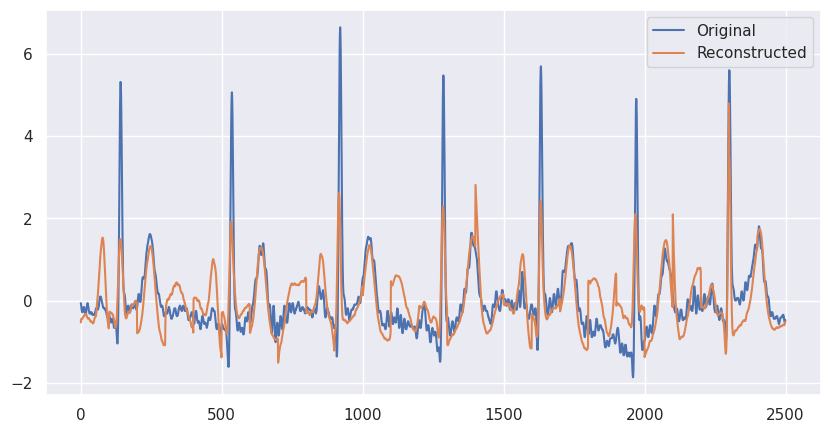

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10,5));
plt.plot(signl_wndw, label='Original');
plt.plot(pred, label='Reconstructed');
plt.legend()

In [11]:
flds

{'fs': 500,
 'sig_len': 10000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['ECG I', 'ECG I filtered'],
 'comments': ['Age: 25', 'Sex: male', 'ECG date: 12.05.2005']}

In [10]:
signals = {}

for prsn in range(10,20):

    signals[prsn] = []

    signl, flds = wfdb.rdsamp(f'/data/nabil/ecg-id-database-1.0.0/Person_{prsn}/rec_1')    

    for st_time in range(0,len(signl)-2500+1,500):

        signl_wndw = signl[st_time:st_time+2500,1]
        signl_wndw = (signl_wndw-np.mean(signl_wndw))/(np.std(signl_wndw)+1e-6)
        
        signals[prsn].append([signl_wndw])

    signl, flds = wfdb.rdsamp(f'/data/nabil/ecg-id-database-1.0.0/Person_{prsn}/rec_2')

    for st_time in range(0,len(signl)-2500+1,500):

        signl_wndw = signl[st_time:st_time+2500,1]
        signl_wndw = (signl_wndw-np.mean(signl_wndw))/(np.std(signl_wndw)+1e-6)
        
        signals[prsn].append([signl_wndw])


    signals[prsn] = np.array(signals[prsn])

In [11]:
embeddings = {}

msk_ratio = 0.0

for prsn in signals:

    x = torch.Tensor(signals[prsn])
    ids_shuffle, ids_restore, ids_keep = mdl_bnk.propose_masking(len(signals[prsn]), mdl_bnk.num_patches, msk_ratio)

    latent, mask = mdl_bnk.maes[0].forward_encoder(x, msk_ratio, ids_shuffle, ids_restore, ids_keep)

    embeddings[prsn] = latent[:,0,:].detach().numpy()

In [131]:
data = []
target = []

for prsn in embeddings:
    for i in range(len(embeddings[prsn])):

        data.append(embeddings[prsn][i])
        target.append(prsn)

data = np.array(data)
target = np.array(target)

<Axes: >

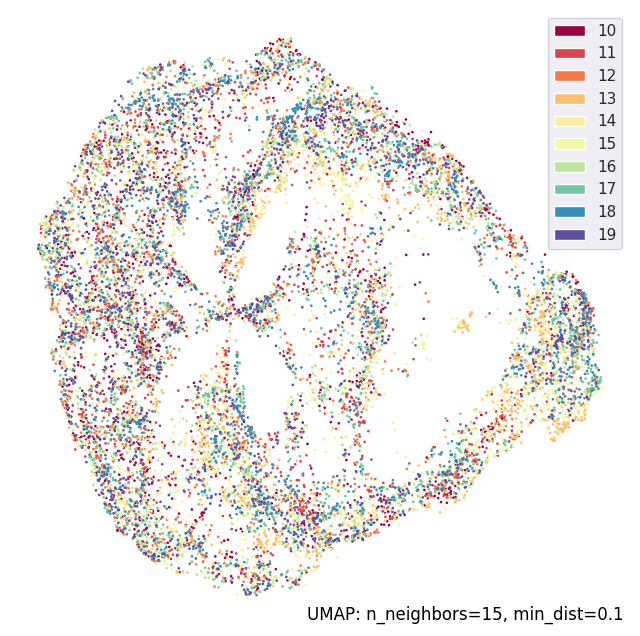

In [132]:
import umap
import umap.plot

embedding = umap.UMAP(n_neighbors=8,
                      min_dist=0.3,
                      metric='correlation').fit(data)

embedding = umap.UMAP().fit(data)
umap.plot.points(embedding, labels=target)

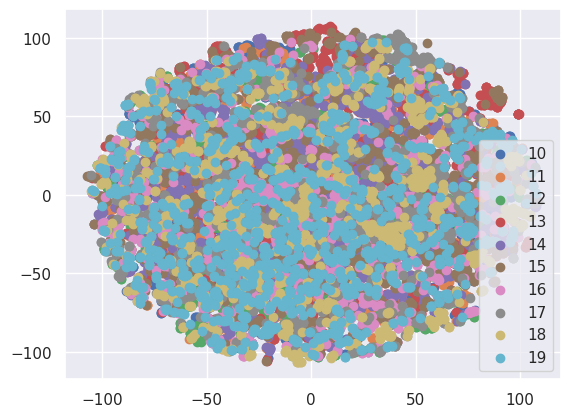

In [133]:
from sklearn.manifold import TSNE

data_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(data)

x1 = {}
x2 = {}

for i in range(len(data_embedded)):

    if target[i] not in x1:
        x1[target[i]] = []
        x2[target[i]] = []

    x1[target[i]].append(data_embedded[i][0])
    x2[target[i]].append(data_embedded[i][1])

cnt = 0
for prsn in x1:
    plt.scatter(x1[prsn],x2[prsn],label=prsn)
    if cnt==10:
        break
    cnt += 1
plt.legend()

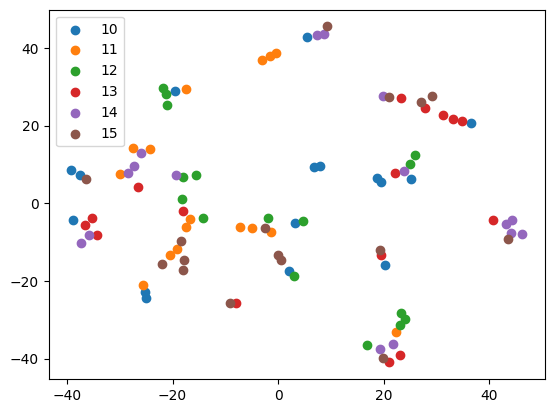

## Probing

In [4]:
import wfdb
from tqdm import tqdm
import torch
import numpy as np

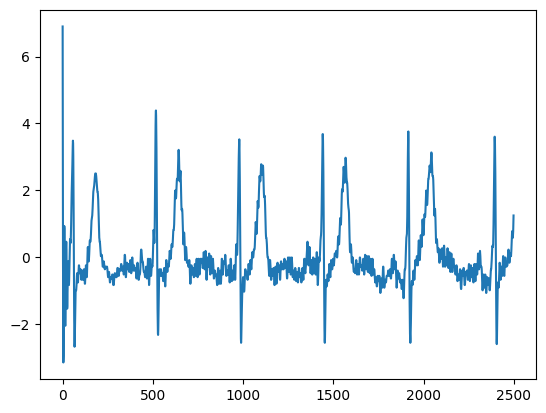

In [37]:
import matplotlib.pyplot as plt
plt.plot(signals_rec2[89][0,0])

In [5]:
signals_rec1 = {}
signals_rec2 = {}

sgnl_chnl = 1
stp_sz = 500

for prsn in tqdm(range(1,91)):

    if prsn==74:
        continue

    signals_rec1[prsn] = []
    signals_rec2[prsn] = []

    signl, flds = wfdb.rdsamp(f'/data/nabil/ecg-id-database-1.0.0/Person_{"" if prsn>9 else "0"}{prsn}/rec_1')    

    for st_time in range(0,len(signl)-2500+1,stp_sz):

        signl_wndw = signl[st_time:st_time+2500,sgnl_chnl]
        signl_wndw = (signl_wndw-np.mean(signl_wndw))/(np.std(signl_wndw)+1e-6)
        
        signals_rec1[prsn].append([signl_wndw])

    signals_rec1[prsn] = np.array(signals_rec1[prsn])

    signl, flds = wfdb.rdsamp(f'/data/nabil/ecg-id-database-1.0.0/Person_{"" if prsn>9 else "0"}{prsn}/rec_2')

    for st_time in range(0,len(signl)-2500+1,stp_sz):

        signl_wndw = signl[st_time:st_time+2500,sgnl_chnl]
        signl_wndw = (signl_wndw-np.mean(signl_wndw))/(np.std(signl_wndw)+1e-6)
        
        signals_rec2[prsn].append([signl_wndw])


    signals_rec2[prsn] = np.array(signals_rec2[prsn])

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:00<00:00, 166.64it/s]


In [ ]:
## OLD 
## OLD 
## OLD 
## OLD 
## OLD 


cls_tokens_rec1 = {}

msk_ratio = 0.75
n_tries = 5

#for prsn in tqdm(signals_rec1):
for prsn in tqdm(range(1,91)):

    for i in range(n_tries):

        x = torch.Tensor(signals_rec1[prsn])
        ids_shuffle, ids_restore, ids_keep = mdl_bnk.propose_masking(len(signals_rec1[prsn]), mdl_bnk.num_patches, msk_ratio)

        latent, mask = mdl_bnk.maes[0].forward_encoder(x, msk_ratio, ids_shuffle, ids_restore, ids_keep)

        if i==0:
            cls_tokens_rec1[prsn] = latent[:,0,:].detach().numpy()
        else:
            cls_tokens_rec1[prsn] += latent[:,0,:].detach().numpy()

        cls_tokens_rec1[prsn] /= n_tries

In [15]:
## OLD 
## OLD 
## OLD 
## OLD 
## OLD 

cls_tokens_rec2 = {}

msk_ratio = 0.75
n_tries = 10

#for prsn in tqdm(signals_rec2):
for prsn in tqdm(range(1,11)):

    for i in range(n_tries):

        x = torch.Tensor(signals_rec2[prsn])
        ids_shuffle, ids_restore, ids_keep = mdl_bnk.propose_masking(len(signals_rec2[prsn]), mdl_bnk.num_patches, msk_ratio)

        latent, mask = mdl_bnk.maes[0].forward_encoder(x, msk_ratio, ids_shuffle, ids_restore, ids_keep)

        if i==0:
            cls_tokens_rec2[prsn] = latent[:,0,:].detach().numpy()
        else:
            cls_tokens_rec2[prsn] += latent[:,0,:].detach().numpy()

        cls_tokens_rec2[prsn] /= n_tries

100%|██████████| 10/10 [00:38<00:00,  3.83s/it]


In [149]:
a.shape

torch.Size([3, 3])

In [6]:
devc = 'cuda:3'

In [7]:
mdl_bnk.maes[0].to(devc);

In [8]:
cls_tokens_rec1 = {}

msk_ratio = 0.00
n_tries = 1

#for prsn in tqdm(signals_rec1):
for prsn in tqdm(range(1,91)):    

    if prsn==74:
        continue

    with torch.no_grad():
        x = torch.Tensor(signals_rec1[prsn])
        x = x.repeat(n_tries,1,1)    

        ids_shuffle, ids_restore, ids_keep = mdl_bnk.propose_masking(len(x), mdl_bnk.num_patches, msk_ratio)

        x = x.to(devc)
        ids_shuffle = ids_shuffle.to(devc)
        ids_restore = ids_restore.to(devc)
        ids_keep = ids_keep.to(devc)

        latent, mask = mdl_bnk.maes[0].forward_encoder(x, msk_ratio, ids_shuffle, ids_restore, ids_keep)

        latent = torch.mean(latent.reshape(n_tries,latent.shape[0]//n_tries,latent.shape[1],latent.shape[2]),dim=0)

        x = x.to('cpu')
        ids_shuffle = ids_shuffle.to('cpu')
        ids_restore = ids_restore.to('cpu')
        ids_keep = ids_keep.to('cpu')
        latent = latent.to('cpu')
        mask = mask.to('cpu')

        cls_tokens_rec1[prsn] = latent[:,0,:].detach().numpy()
        #cls_tokens_rec1[prsn] = torch.mean(latent,dim=1).detach().numpy()

100%|██████████| 90/90 [00:01<00:00, 45.14it/s]


In [224]:
torch.mean(latent,dim=1).shape

torch.Size([16, 768])

In [9]:
cls_tokens_rec2 = {}

msk_ratio = 0.0
n_tries = 1

for prsn in tqdm(range(1,91)):    

    if prsn==74:
        continue
    
    with torch.no_grad():
        x = torch.Tensor(signals_rec2[prsn])
        x = x.repeat(n_tries,1,1)    

        ids_shuffle, ids_restore, ids_keep = mdl_bnk.propose_masking(len(x), mdl_bnk.num_patches, msk_ratio)

        x = x.to(devc)
        ids_shuffle = ids_shuffle.to(devc)
        ids_restore = ids_restore.to(devc)
        ids_keep = ids_keep.to(devc)

        latent, mask = mdl_bnk.maes[0].forward_encoder(x, msk_ratio, ids_shuffle, ids_restore, ids_keep)

        latent = torch.mean(latent.reshape(n_tries,latent.shape[0]//n_tries,latent.shape[1],latent.shape[2]),dim=0)


        x = x.to('cpu')
        ids_shuffle = ids_shuffle.to('cpu')
        ids_restore = ids_restore.to('cpu')
        ids_keep = ids_keep.to('cpu')
        latent = latent.to('cpu')
        mask = mask.to('cpu')

        cls_tokens_rec2[prsn] = latent[:,0,:].detach().numpy()
        #cls_tokens_rec2[prsn] = torch.mean(latent,dim=1).detach().numpy()

100%|██████████| 90/90 [00:01<00:00, 47.95it/s]


In [11]:
x.shape

torch.Size([16, 1, 2500])

In [10]:
X_rec1 = []
Y_rec1 = []

X_rec2 = []
Y_rec2 = []

for prsn in cls_tokens_rec1:

    if(len(X_rec1)==0):
        X_rec1 = cls_tokens_rec1[prsn]
        Y_rec1.extend([prsn]*len(cls_tokens_rec1[prsn]))
    else:
        X_rec1 = np.vstack([X_rec1,cls_tokens_rec1[prsn]])
        Y_rec1.extend([prsn]*len(cls_tokens_rec1[prsn]))


for prsn in cls_tokens_rec2:

    if(len(X_rec2)==0):
        X_rec2 = cls_tokens_rec2[prsn]
        Y_rec2.extend([prsn]*len(cls_tokens_rec2[prsn]))
    else:
        X_rec2 = np.vstack([X_rec2,cls_tokens_rec2[prsn]])
        Y_rec2.extend([prsn]*len(cls_tokens_rec2[prsn]))


In [293]:
np.hstack([Y_rec1,Y_rec2])

array([ 1,  1,  1, ..., 90, 90, 90])

/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/umap/distances.py:1086: 

<Axes: >

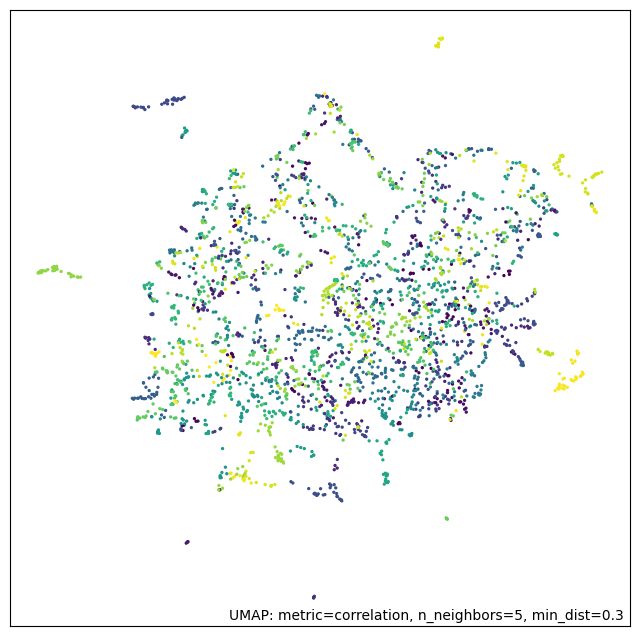

In [12]:
import umap
import umap.plot

embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit(np.vstack([X_rec1,X_rec2]))

#embedding = umap.UMAP().fit(X_rec2)
#umap.plot.points(embedding, labels=np.hstack([Y_rec1,Y_rec2]),color_key_cmap='cet_glasbey_light')
umap.plot.points(embedding, labels=np.hstack([Y_rec1,Y_rec2]),color_key_cmap='viridis',show_legend=False)


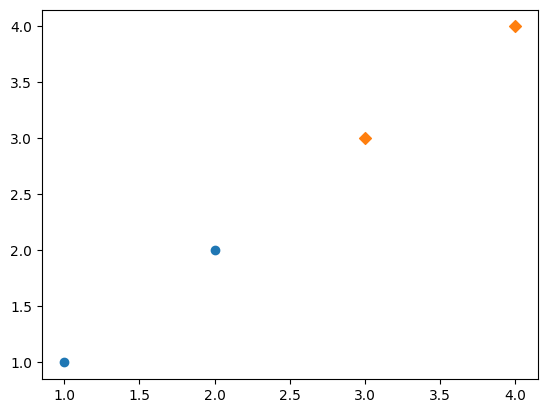

In [14]:
plt.scatter([1,2],[1,2],c='#1f77b4', marker='o')# o ,s,v, *, D , X, P              ,d           p
plt.scatter([3,4],[3,4],c='#ff7f0e', marker='D')

markers = ['o' ,'s','v', '*', 'X', 'P']#'D' ,               ,'d'           ,'p']
colors = ['#000000' ,
'#263238' ,
'#607d8b',
'#616161',
'#cfd8dc',
'#795548',
'#0d47a1',
'#1a237e',
'#2979ff',
'#82b1ff',
'#7986cb',
'#ff3d00',
'#ff8a65',
'#ffff00',
'#ff6f00',
'#76ff03',
'#33691e',
'#c6ff00',
'#69f0ae',
'#69f0ae',
'#18ffff',
'#006064',
'#311b92',
'#4a148c',
'#e040fb',
'#ff1744',
'#e91e63']

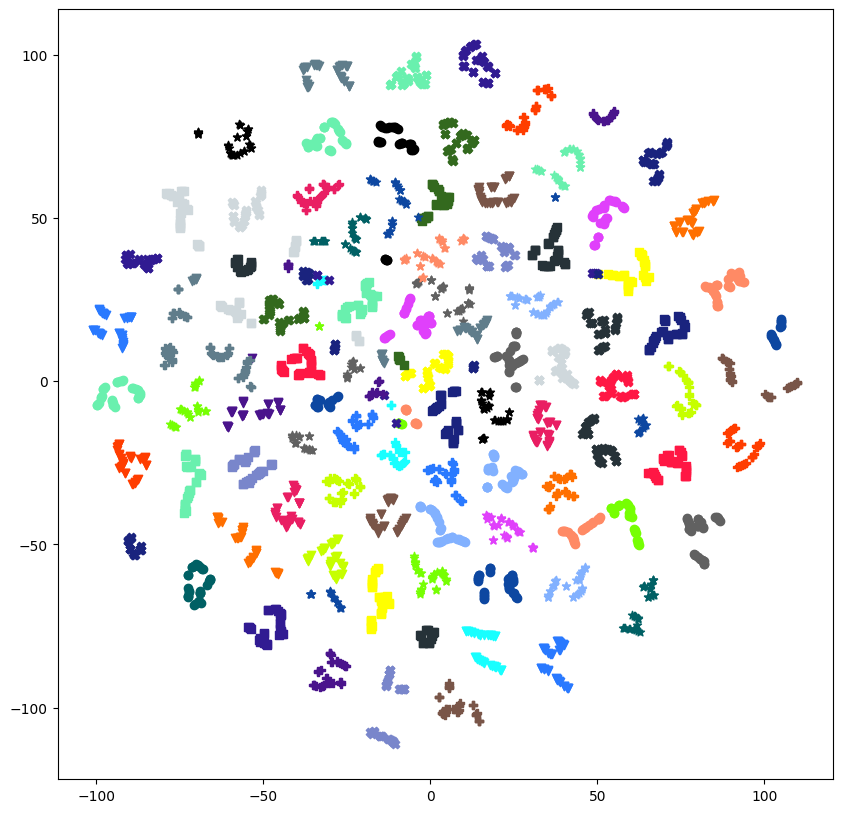

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=2, perplexity=5).fit_transform(np.vstack([X_rec1,X_rec2]))
target = np.hstack([Y_rec1,Y_rec2])

x1 = {}
x2 = {}

for i in range(len(data_embedded)):

    if target[i] not in x1:
        x1[target[i]] = []
        x2[target[i]] = []

    x1[target[i]].append(data_embedded[i][0])
    x2[target[i]].append(data_embedded[i][1])

cnt = 0


plt.figure(figsize=(10,10))

for prsn in x1:
    plt.scatter(x1[prsn],x2[prsn],label=prsn, c= colors[prsn%len(colors)], marker=markers[prsn%len(markers)])
    if cnt==10:
        pass
    cnt += 1
#plt.legend()

In [328]:
len(colors)

27

In [286]:
embedding

UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.3, n_neighbors=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
sclr.mean_

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sclr = MinMaxScaler()
sclr.fit(X_rec1)
X_rec1 = sclr.transform(X_rec1)
X_rec2 = sclr.transform(X_rec2)

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_rec2, Y_rec2)

y_pred1 = knn.predict(X_rec1)

In [254]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=100, random_state=0)
rf.fit(X_rec2, Y_rec2)

y_pred1 = rf.predict(X_rec1)

In [259]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes = (256,128) , random_state=1, max_iter=300, shuffle = True, early_stopping=True)
mlp.fit(X_rec2, Y_rec2)

y_pred1 = mlp.predict(X_rec1)

In [208]:
from sklearn.svm import SVC

clf =   SVC(gamma=5, C=10)
clf.fit(X_rec2, Y_rec2)

y_pred1 = clf.predict(X_rec1)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(Y_rec1, y_pred1))


              precision    recall  f1-score   support

           1       1.00      0.31      0.48        16
           2       1.00      1.00      1.00        16
           3       0.55      0.38      0.44        16
           4       0.94      0.94      0.94        16
           5       1.00      1.00      1.00        16
           6       1.00      0.69      0.81        16
           7       1.00      0.25      0.40        16
           8       0.84      1.00      0.91        16
           9       1.00      1.00      1.00        16
          10       1.00      0.44      0.61        16
          11       0.93      0.88      0.90        16
          12       1.00      0.94      0.97        16
          13       0.94      1.00      0.97        16
          14       0.60      0.94      0.73        16
          15       1.00      0.94      0.97        16
          16       0.75      0.94      0.83        16
          17       1.00      1.00      1.00        16
          18       0.89    

/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_rec1, Y_rec1)

y_pred2 = knn.predict(X_rec2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=10, random_state=0)
rf.fit(X_rec1, Y_rec1)

y_pred2 = rf.predict(X_rec2)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes = (512,256) , random_state=1, max_iter=300, shuffle = True, early_stopping=True)
rf.fit(X_rec1, Y_rec1)

y_pred2 = rf.predict(X_rec2)

In [ ]:
from sklearn.svm import SVC

clf =   SVC(gamma=2, C=1)
clf.fit(X_rec1, Y_rec1)

y_pred2 = clf.predict(X_rec2)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(Y_rec2, y_pred2))


              precision    recall  f1-score   support

           1       0.79      0.69      0.73        16
           2       1.00      1.00      1.00        16
           3       0.00      0.00      0.00        16
           4       1.00      0.69      0.81        16
           5       1.00      1.00      1.00        16
           6       1.00      0.94      0.97        16
           7       0.92      0.69      0.79        16
           8       0.76      1.00      0.86        16
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        16
          11       1.00      0.94      0.97        16
          12       1.00      1.00      1.00        16
          13       1.00      0.88      0.93        16
          14       0.91      0.62      0.74        16
          15       0.89      1.00      0.94        16
          16       0.44      0.69      0.54        16
          17       1.00      1.00      1.00        16
          18       0.76    

In [83]:
Y_rec1_re = []
Y_rec2_re = []

for y in Y_rec1:
    if y>74:
        Y_rec1_re.append(y-2)
    else:        
        Y_rec1_re.append(y-1)

for y in Y_rec2:
    if y>74:
        Y_rec2_re.append(y-2)
    else:        
        Y_rec2_re.append(y-1)

In [84]:
import xgboost as xgb

dtrain1 = xgb.DMatrix(X_rec1, label=Y_rec1_re)
dtrain2 = xgb.DMatrix(X_rec2, label=Y_rec2_re)

param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax', 'num_class':89}
param['nthread'] = 4
param['eval_metric'] = 'merror'

evallist = [(dtrain1, 'train'), (dtrain2, 'eval')]

num_round = 10
bst1 = xgb.train(param, dtrain1, num_round, evallist)

/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-merror:0.06875	eval-merror:0.53859
[1]	train-merror:0.03489	eval-merror:0.52602
[2]	train-merror:0.01671	eval-merror:0.52203
[3]	train-merror:0.01094	eval-merror:0.50739
[4]	train-merror:0.00813	eval-merror:0.49808
[5]	train-merror:0.00488	eval-merror:0.48625
[6]	train-merror:0.00444	eval-merror:0.48137
[7]	train-merror:0.00414	eval-merror:0.47871
[8]	train-merror:0.00355	eval-merror:0.47915
[9]	train-merror:0.00296	eval-merror:0.47620


In [86]:
y_pred12 = bst1.predict(dtrain2)


In [89]:
from sklearn.metrics import classification_report

print(classification_report(Y_rec2_re, y_pred12))


              precision    recall  f1-score   support

           0       0.28      0.25      0.27        76
           1       0.42      0.28      0.33        76
           2       0.30      0.20      0.24        76
           3       0.43      0.26      0.33        76
           4       0.84      0.86      0.85        76
           5       0.62      0.34      0.44        76
           6       0.58      0.55      0.57        76
           7       0.79      1.00      0.88        76
           8       0.68      0.47      0.56        76
           9       0.56      0.18      0.28        76
          10       0.72      0.41      0.52        76
          11       0.75      0.47      0.58        76
          12       0.97      0.75      0.84        76
          13       0.89      0.54      0.67        76
          14       0.13      0.12      0.12        76
          15       0.32      0.22      0.26        76
          16       0.92      0.89      0.91        76
          17       0.85    

In [74]:
from sklearn.metrics import classification_report

print(classification_report(Y_rec2, y_pred2))


              precision    recall  f1-score   support

           1       0.40      0.21      0.28        76
           2       0.75      1.00      0.86        76
           3       0.39      0.21      0.27        76
           4       0.87      0.86      0.86        76
           5       1.00      1.00      1.00        76
           6       0.67      0.70      0.68        76
           7       0.61      0.67      0.64        76
           8       0.49      1.00      0.66        76
           9       0.71      0.72      0.72        76
          10       1.00      0.71      0.83        76
          11       0.91      0.95      0.93        76
          12       0.99      1.00      0.99        76
          13       0.80      0.84      0.82        76
          14       0.87      0.26      0.40        76
          15       0.46      0.95      0.62        76
          16       0.48      0.55      0.51        76
          17       0.97      1.00      0.99        76
          18       0.76    

/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
from sklearn.metrics import classification_report

print(classification_report(Y_rec1, y_pred1))


              precision    recall  f1-score   support

           1       0.52      0.34      0.41        76
           2       0.75      0.71      0.73        76
           3       0.71      0.36      0.47        76
           4       0.55      0.88      0.68        76
           5       1.00      1.00      1.00        76
           6       0.89      0.67      0.77        76
           7       0.98      0.57      0.72        76
           8       0.86      1.00      0.93        76
           9       1.00      1.00      1.00        76
          10       0.76      0.93      0.84        76
          11       0.47      0.61      0.53        76
          12       0.92      1.00      0.96        76
          13       0.97      1.00      0.99        76
          14       0.47      1.00      0.64        76
          15       0.95      0.91      0.93        76
          16       0.20      0.11      0.14        76
          17       0.75      1.00      0.86        76
          18       0.99    

In [187]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_rec2, y_pred2)

<Axes: >

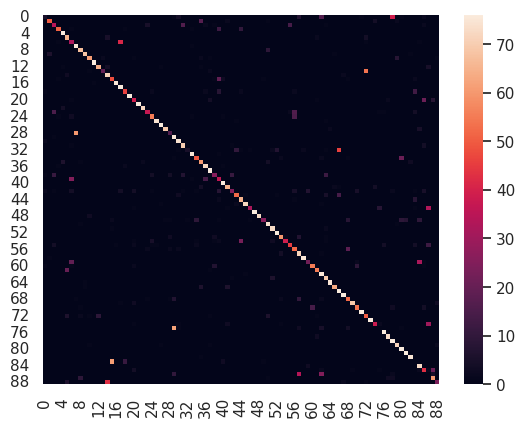

In [188]:
sns.heatmap(cm)

<Axes: >

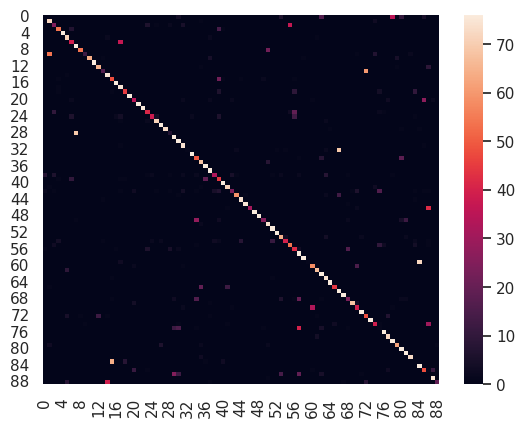

In [167]:
sns.heatmap(cm)